# 1. FER2013 VGG19 분류

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
import tensorflow as tf
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

import keras.backend.tensorflow_backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Add, Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D
from keras.optimizers import Adam, Adadelta
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image

Using TensorFlow backend.


## 1.1. 학습에 사용될 하이퍼 패러미터 선언 및 Random Seed 설정

In [2]:
np.random.seed(201)

In [3]:
FER2013_DIR = "datasets/fer2013/prep/"
INPUT_TRAIN_DATA = 'fer2013_X.npy'
LABEL_TRAIN_DATA = 'fer2013_y.npy'

TEST_SPLIT = 0.2
RND_SEED = 0

In [4]:
input_data = np.load(open(FER2013_DIR + INPUT_TRAIN_DATA, 'rb'))
label_data = np.load(open(FER2013_DIR + LABEL_TRAIN_DATA, 'rb'))

In [5]:
input_data = np.squeeze(input_data)
input_data = np.stack((input_data,)*3, axis=3)

In [6]:
input_shape = input_data[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (48, 48, 3)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(input_data,
                                                    label_data,
                                                    test_size=TEST_SPLIT,
                                                    random_state=RND_SEED)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=TEST_SPLIT,
                                                  random_state=RND_SEED)

In [9]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(9641, 48, 48, 3)
(2411, 48, 48, 3)
(3014, 48, 48, 3)


## 1.2 CNN모델 정의

모델 컴파일

In [10]:
base_model = VGG19(weights=None, include_top=False, input_shape=(48, 48, 3))

In [11]:
x = base_model.output
x = Flatten()(x)
predictions = Dense(2, activation='softmax')(x)

In [12]:
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

모델 플롯 생성

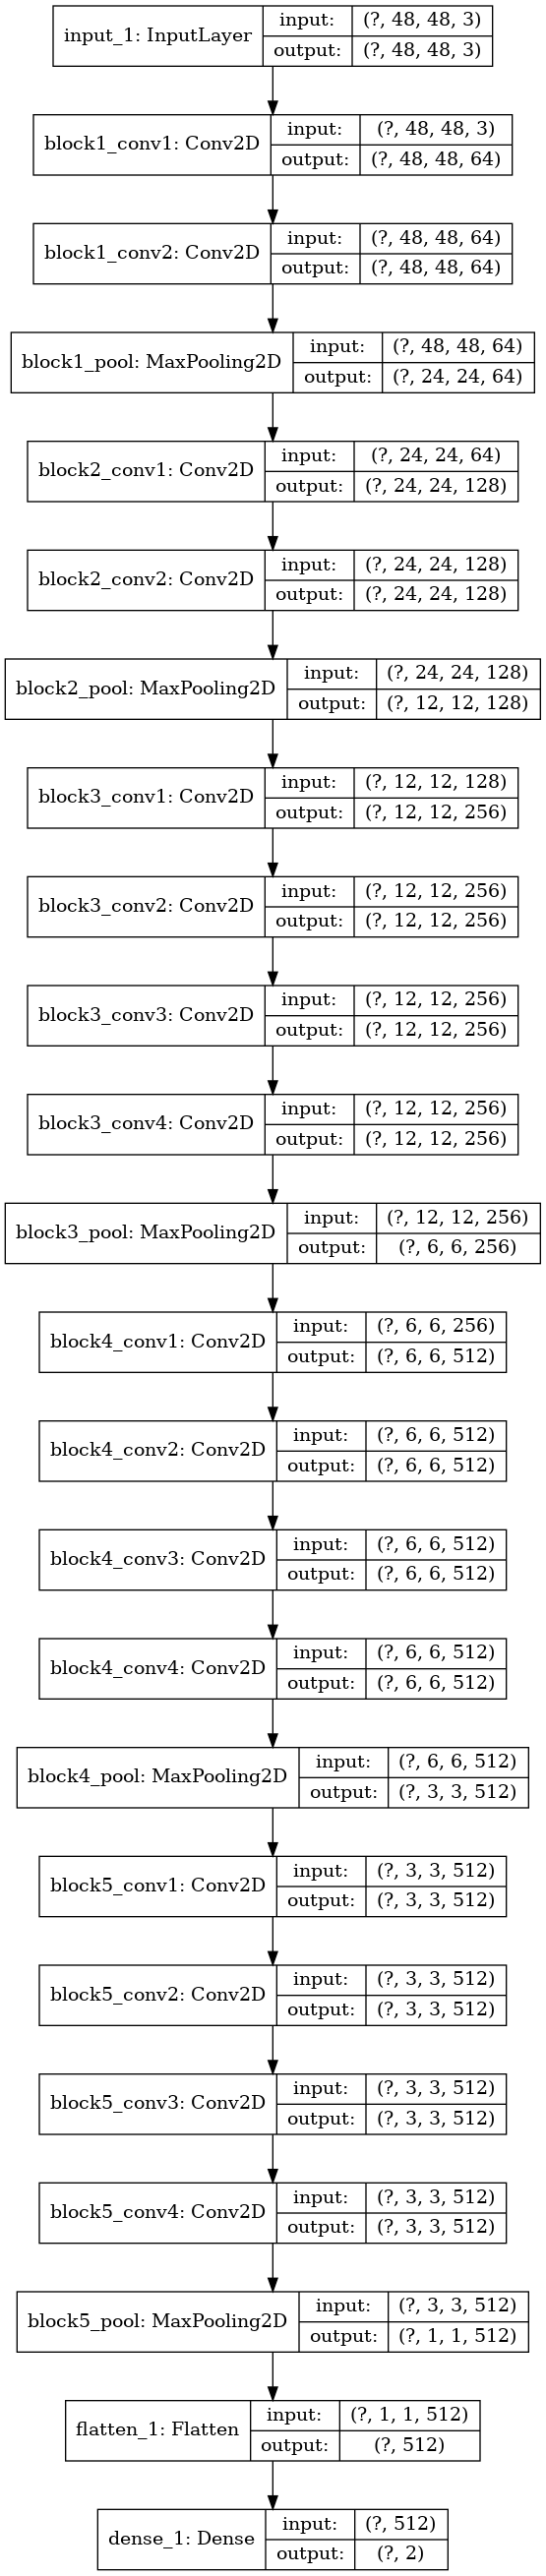

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [16]:
MODEL_PATH = 'weights.h5f'

In [17]:
check_point = ModelCheckpoint(filepath=MODEL_PATH, monitor='val_accuracy', verbose=1, save_best_only=True)

## 1.3 CNN 모델 훈련

In [18]:
batch_size = 32
epochs = 100

In [19]:
# Training
with K.tf_ops.device('/device:GPU:0'):
    history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size,
                        validation_data = (x_val, y_val), callbacks=[check_point])

Train on 9641 samples, validate on 2411 samples
Epoch 1/100
9641/9641 [==============================] - 11s 1ms/step - loss: 1.0879 - accuracy: 0.5966 - val_loss: 0.6768 - val_accuracy: 0.5915

Epoch 00001: val_accuracy improved from -inf to 0.59146, saving model to weights.h5f
Epoch 2/100
9641/9641 [==============================] - 9s 902us/step - loss: 0.6746 - accuracy: 0.5977 - val_loss: 0.6766 - val_accuracy: 0.5915

Epoch 00002: val_accuracy did not improve from 0.59146
Epoch 3/100
9641/9641 [==============================] - 9s 902us/step - loss: 0.6747 - accuracy: 0.5977 - val_loss: 0.6766 - val_accuracy: 0.5915

Epoch 00003: val_accuracy did not improve from 0.59146
Epoch 4/100
9641/9641 [==============================] - 9s 903us/step - loss: 0.6740 - accuracy: 0.5977 - val_loss: 0.6764 - val_accuracy: 0.5915

Epoch 00004: val_accuracy did not improve from 0.59146
Epoch 5/100
9641/9641 [==============================] - 9s 897us/step - loss: 0.6745 - accuracy: 0.5977 - val_

9641/9641 [==============================] - 9s 913us/step - loss: 0.6741 - accuracy: 0.5977 - val_loss: 0.6768 - val_accuracy: 0.5915

Epoch 00041: val_accuracy did not improve from 0.59146
Epoch 42/100
9641/9641 [==============================] - 9s 900us/step - loss: 0.6740 - accuracy: 0.5977 - val_loss: 0.6764 - val_accuracy: 0.5915

Epoch 00042: val_accuracy did not improve from 0.59146
Epoch 43/100
9641/9641 [==============================] - 9s 902us/step - loss: 0.6742 - accuracy: 0.5977 - val_loss: 0.6764 - val_accuracy: 0.5915

Epoch 00043: val_accuracy did not improve from 0.59146
Epoch 44/100
9641/9641 [==============================] - 9s 906us/step - loss: 0.6741 - accuracy: 0.5977 - val_loss: 0.6763 - val_accuracy: 0.5915

Epoch 00044: val_accuracy did not improve from 0.59146
Epoch 45/100
9641/9641 [==============================] - 9s 908us/step - loss: 0.6741 - accuracy: 0.5977 - val_loss: 0.6763 - val_accuracy: 0.5915

Epoch 00045: val_accuracy did not improve from 0

9641/9641 [==============================] - 9s 908us/step - loss: 0.6741 - accuracy: 0.5977 - val_loss: 0.6764 - val_accuracy: 0.5915

Epoch 00081: val_accuracy did not improve from 0.59146
Epoch 82/100
9641/9641 [==============================] - 9s 904us/step - loss: 0.6741 - accuracy: 0.5977 - val_loss: 0.6764 - val_accuracy: 0.5915

Epoch 00082: val_accuracy did not improve from 0.59146
Epoch 83/100
9641/9641 [==============================] - 9s 904us/step - loss: 0.6740 - accuracy: 0.5977 - val_loss: 0.6764 - val_accuracy: 0.5915

Epoch 00083: val_accuracy did not improve from 0.59146
Epoch 84/100
9641/9641 [==============================] - 9s 905us/step - loss: 0.6741 - accuracy: 0.5977 - val_loss: 0.6765 - val_accuracy: 0.5915

Epoch 00084: val_accuracy did not improve from 0.59146
Epoch 85/100
9641/9641 [==============================] - 9s 908us/step - loss: 0.6740 - accuracy: 0.5977 - val_loss: 0.6763 - val_accuracy: 0.5915

Epoch 00085: val_accuracy did not improve from 0

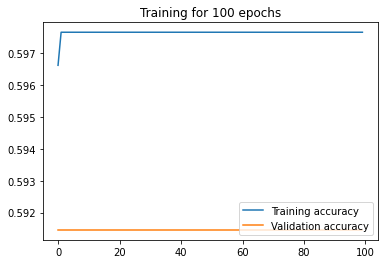

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

검증셋 정확도

In [21]:
model.load_weights(MODEL_PATH)
results = model.evaluate(x_val, y_val)
print('Test accuracy: ', results[1])

2411/2411 [==============================] - 1s 359us/step
Test accuracy:  0.5914558172225952


테스트셋 정확도

In [22]:
results = model.evaluate(x_test, y_test)
print('Test accuracy: ', results[1])

3014/3014 [==============================] - 1s 409us/step
Test accuracy:  0.59754478931427


## 1.3 K-fold  Cross Validation 이용

In [23]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [24]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=RND_SEED, shuffle=True)

for train_index, test_index in kf.split(input_data):
    X_train, X_test = input_data[train_index], input_data[test_index]
    Y_train, Y_test = label_data[train_index], label_data[test_index]

In [25]:
with K.tf_ops.device('/device:GPU:0'):
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size,
                        validation_data = (X_test, Y_test), callbacks=[check_point])

Train on 13560 samples, validate on 1506 samples
Epoch 1/100
13560/13560 [==============================] - 12s 919us/step - loss: 0.6753 - accuracy: 0.5962 - val_loss: 0.6737 - val_accuracy: 0.6009

Epoch 00001: val_accuracy improved from 0.59146 to 0.60093, saving model to weights.h5f
Epoch 2/100
13560/13560 [==============================] - 12s 855us/step - loss: 0.6751 - accuracy: 0.5962 - val_loss: 0.6727 - val_accuracy: 0.6009

Epoch 00002: val_accuracy did not improve from 0.60093
Epoch 3/100
13560/13560 [==============================] - 12s 858us/step - loss: 0.6748 - accuracy: 0.5962 - val_loss: 0.6728 - val_accuracy: 0.6009

Epoch 00003: val_accuracy did not improve from 0.60093
Epoch 4/100
13560/13560 [==============================] - 12s 854us/step - loss: 0.6750 - accuracy: 0.5962 - val_loss: 0.6727 - val_accuracy: 0.6009

Epoch 00004: val_accuracy did not improve from 0.60093
Epoch 5/100
13560/13560 [==============================] - 12s 857us/step - loss: 0.6749 - acc

13560/13560 [==============================] - 12s 855us/step - loss: 0.6746 - accuracy: 0.5962 - val_loss: 0.6726 - val_accuracy: 0.6009

Epoch 00040: val_accuracy did not improve from 0.60093
Epoch 41/100
13560/13560 [==============================] - 12s 859us/step - loss: 0.6747 - accuracy: 0.5962 - val_loss: 0.6727 - val_accuracy: 0.6009

Epoch 00041: val_accuracy did not improve from 0.60093
Epoch 42/100
13560/13560 [==============================] - 12s 860us/step - loss: 0.6746 - accuracy: 0.5962 - val_loss: 0.6728 - val_accuracy: 0.6009

Epoch 00042: val_accuracy did not improve from 0.60093
Epoch 43/100
13560/13560 [==============================] - 12s 867us/step - loss: 0.6746 - accuracy: 0.5962 - val_loss: 0.6727 - val_accuracy: 0.6009

Epoch 00043: val_accuracy did not improve from 0.60093
Epoch 44/100
13560/13560 [==============================] - 12s 856us/step - loss: 0.6746 - accuracy: 0.5962 - val_loss: 0.6728 - val_accuracy: 0.6009

Epoch 00044: val_accuracy did not


Epoch 00079: val_accuracy did not improve from 0.60093
Epoch 80/100
13560/13560 [==============================] - 12s 854us/step - loss: 0.6746 - accuracy: 0.5962 - val_loss: 0.6727 - val_accuracy: 0.6009

Epoch 00080: val_accuracy did not improve from 0.60093
Epoch 81/100
13560/13560 [==============================] - 12s 857us/step - loss: 0.6746 - accuracy: 0.5962 - val_loss: 0.6727 - val_accuracy: 0.6009

Epoch 00081: val_accuracy did not improve from 0.60093
Epoch 82/100
13560/13560 [==============================] - 12s 850us/step - loss: 0.6746 - accuracy: 0.5962 - val_loss: 0.6728 - val_accuracy: 0.6009

Epoch 00082: val_accuracy did not improve from 0.60093
Epoch 83/100
13560/13560 [==============================] - 12s 850us/step - loss: 0.6745 - accuracy: 0.5962 - val_loss: 0.6726 - val_accuracy: 0.6009

Epoch 00083: val_accuracy did not improve from 0.60093
Epoch 84/100
13560/13560 [==============================] - 12s 853us/step - loss: 0.6746 - accuracy: 0.5962 - val_l

테스트셋 정확도

In [26]:
results = model.evaluate(x_test, y_test)
print('Test accuracy: ', results[1])

3014/3014 [==============================] - 1s 379us/step
Test accuracy:  0.59754478931427
